<a href="https://colab.research.google.com/github/Mrajie88/Competition/blob/master/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import time
import torch
from mpl_toolkits.mplot3d import Axes3D
import os

In [9]:
print("cpu" if not torch.cuda.is_available() else torch.cuda.get_device_name())
device = "cpu" if not torch.cuda.is_available() else "gpu"

Tesla T4


In [0]:
path = "/content/drive/My Drive/"
train_df_source = pd.read_csv(path+'train.csv')
test_df_source = pd.read_csv(path+'test.csv')
event_df_source = pd.read_csv(path+'event.csv')

In [0]:
def f_eng(df, event_df, is_train=True):
    df = pd.merge(df, event_df.loc[:, ['event_id', 'energymc', 'thetamc', 'phimc', 'xcmc', 'ycmc']], how='left',
                  on='event_id')
    # df['dis'] = np.sqrt(df['x']**2+df['y']**2+df['t']**2)
    # 时间差
    df['t_o']=df['t']-df['terror']

    df['q_mean'] = df['q']-df['q'].groupby(df['event_id']).transform(np.mean)
    df['t_mean'] = df['t']-df['t'].groupby(df['event_id']).transform(np.mean)
    df['t_std'] = df["t"].groupby(df["event_id"]).transform(np.std)
    df['t_ptp'] = df["t"].groupby(df["event_id"]).transform(np.ptp)
    df["x_xcmc"] = df["x"]-df["xcmc"]
    df["y_ycmc"] = df["y"] - df["ycmc"]
    df["dis"] = np.sqrt(df["x_xcmc"] ** 2+df["y_ycmc"] ** 2 +df["t"] ** 2)
    
    if is_train:
        df = df.drop('flag', axis=1)
    df = df.drop(['hit_id', 'z', 'event_id'], axis=1)
    return df

In [11]:
labels = train_df_source['flag']
train_df = f_eng(train_df_source, event_df_source)
test_df = f_eng(test_df_source, event_df_source, False)
print(train_df.columns.values.tolist())
# 小样本训练
train_df = train_df.iloc[:10000000, :]
labels = labels[:10000000]

train_x, val_x, train_y, val_y = train_test_split(train_df, labels, test_size=0.33, random_state=42)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['x', 'y', 't', 'terror', 'q', 'energymc', 'thetamc', 'phimc', 'xcmc', 'ycmc', 't_o', 'q_mean', 't_mean', 't_std', 't_ptp', 'x_xcmc', 'y_ycmc', 'dis']


In [0]:
params = {
    "task":"train",
    "boosting_type":"gbdt",
    "metric":"auc",
    "num_leaves":255,
    "learning_rate":0.01,
    "feature_fraction":0.9,
    "bagging_fraction":0.8,
    "verbose":200,
    "num_thread": 16,
    "num_interations":10000,
    "early_stopping_round":200
}

In [15]:
t = time.time()
batch_size = 5000000
gbm = None
# 若采取增量训练 读取断点
#with open("/content/drive/My Drive/lgb_model_v0.txt","r") as f:
#  gbm = lgb.Booster({'model_str':f.read()})
print("=========================================================模型读取成功======================================================================================")
max_len = 0
for i in range(0*batch_size,len(train_x),batch_size):
  if i+ batch_size >len(train_x):
    max_len = batch_size
  else:
    max_len = len(train_x)-i-1
  print("=========================================================数据准备======================================================================================")
  lgb_train = lgb.Dataset(train_x.iloc[i:i+max_len,:],train_y.iloc[i:i+max_len])
  lgb_test = lgb.Dataset(val_x,val_y,reference = lgb_train)
  print("=========================================================模型训练======================================================================================")
  gbm = lgb.train(params,lgb_train,init_model = gbm,valid_sets = lgb_test,keep_training_booster=True)
  gbm.save_model("/content/drive/My Drive/lgb_model_v"+str(i//batch_size)+".txt")
  print("============================================================模型训练完成===========================================================================================")
period = time.time()
result = pd.DataFrame(data = [[period,len(train_x),params["learning_rate"],gbm.eval_valid()[0][2]]],index = None,columns=["time","data_size","learning_rate","valid_eval"])
result.to_csv("experiment_record.csv",mode = "a+")

=========================================================模型读取成功======================================================================================
=========================================================数据准备======================================================================================
=========================================================模型训练======================================================================================


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.972701
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's auc: 0.973855
[3]	valid_0's auc: 0.975099
[4]	valid_0's auc: 0.978933
[5]	valid_0's auc: 0.978771
[6]	valid_0's auc: 0.978836
[7]	valid_0's auc: 0.978781
[8]	valid_0's auc: 0.978727
[9]	valid_0's auc: 0.978745
[10]	valid_0's auc: 0.97865
[11]	valid_0's auc: 0.979841
[12]	valid_0's auc: 0.979843
[13]	valid_0's auc: 0.979738
[14]	valid_0's auc: 0.979754
[15]	valid_0's auc: 0.979691
[16]	valid_0's auc: 0.979635
[17]	valid_0's auc: 0.979573
[18]	valid_0's auc: 0.979633
[19]	valid_0's auc: 0.979609
[20]	valid_0's auc: 0.979591
[21]	valid_0's auc: 0.979695
[22]	valid_0's auc: 0.979669
[23]	valid_0's auc: 0.97966
[24]	valid_0's auc: 0.979712
[25]	valid_0's auc: 0.97968
[26]	valid_0's auc: 0.979673
[27]	valid_0's auc: 0.979657
[28]	valid_0's auc: 0.979619
[29]	valid_0's auc: 0.979608
[30]	valid_0's auc: 0.979601
[31]	valid_0's auc: 0.979589
[32]	valid_0's auc: 0.979611
[33]	valid_0's auc: 0

ValueError: ignored

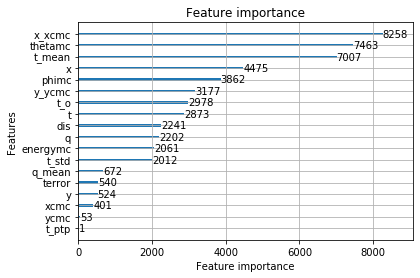

In [26]:
# 模型重要性
lgb.plot_importance(gbm)

In [0]:
# 读取模型和预测test
t = time.time()
#gbm = None
#with open("/content/drive/My Drive/lgb_model_v0.txt","r") as f:
#  gbm = lgb.Booster({'model_str':f.read()})
pred = gbm.predict(test_df)
test_pre = pd.DataFrame(pred, columns=['flag_pred'])
print('test_pre runtime:', time.time() - t)
sub = pd.concat([test_df_source['hit_id'], test_pre,test_df_source['event_id']], axis=1)
#fea_imp_list.append(gbm.feature_importances_)
print('runtime:', time.time() - t)

test_pre runtime: 0.0015943050384521484
runtime: 0.043180227279663086


In [0]:
# sub.to_csv('drive/My Drive/sub_prob_{}_{}_{}.csv'.format(best_auc, best_f1,sub['flag_pred'].mean()),index=False)
best_t = 0.7
sub['flag_pred'] = sub['flag_pred'].apply(lambda x: 1 if x >= best_t else 0)
sub.to_csv('drive/My Drive/submition_{}_{}.csv'.format(time.asctime( time.localtime(time.time()) ),sub['flag_pred'].mean()),index=False)

print('runtime:', time.time() - t)
print('finish.')

runtime: 765.3468747138977
finish.
